### I worked with: Weiwei Zhang, Kate Shijie Xu

### I certify that all solutions are entirely in my own words and that I have not looked at another student’s solutions. I have given credit to all external sources I consulted. 

## #1 Python Configuration and Data Loading



In [12]:
import sys

if sys.version_info[0] < 3:
    raise Exception("Python 3 not detected.")
    
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from scipy import io
from save_csv import results_to_csv

\pagebreak 

# #2 Data Partitioning
#### I created a reusable function that can be applied to all 3 datasets. The data is randomized then split. The way it is split is the first "val_amt" amount of examples get put in the validation set, the rest are put in the training set.

In [38]:
np.random.seed(1)

#first randomized val_amt get puts in validation set, rest in training
def shuffle_train_val_split(name, val_amt=0, percent=0):
    data = io.loadmat("data/%s_data.mat" % name)
    total_num_ex = data["training_data"].shape[0]
    shuffle = np.random.permutation(total_num_ex) #shuffle before split
    data_xtrain, data_ytrain = data["training_data"][shuffle], \
    data["training_labels"][shuffle] #split
    if not val_amt: #spam case
        val_amt = int(percent * total_num_ex)
    data_xval, data_yval = data_xtrain[:val_amt,:], data_ytrain[:val_amt,:]
    data_xtrain, data_ytrain = data_xtrain[val_amt:,:], data_ytrain[val_amt:,:]
    return data_xtrain, data_ytrain, data_xval, data_yval

In [14]:
mnist_xtrain, mnist_ytrain, mnist_xval, mnist_yval = \
shuffle_train_val_split("mnist", 10000) 
spam_xtrain, spam_ytrain, spam_xval, spam_yval = \
shuffle_train_val_split("spam", percent=0.2) 
cifar10_xtrain, cifar10_ytrain, cifar10_xval, cifar10_yval = \
shuffle_train_val_split("cifar10", 5000) 

\pagebreak 

# #3 Support Vector Machines: Coding
#### I preprocess the MNIST data by normalizing it. I also increase the "cache_size" SVC hyperparameter to speed up computing. I also compute and plot the training and validation error rates for MNIST, SPAM, and CIFAR-10 datasets for varying training set sizes.

In [40]:
#preprocessing
mnist_xtrain, mnist_xval = (mnist_xtrain-np.mean(mnist_xtrain))/np.std(mnist_xtrain), \
(mnist_xval-np.mean(mnist_xval))/np.std(mnist_xval)
#remember to normalize test set as well

def train(data_xtrain, data_ytrain, data_xval, data_yval, num_ex, kernel):
    data_ytrain = data_ytrain.reshape(-1,)
    data_yval = data_yval.reshape(-1,)
    model = svm.SVC(kernel=kernel, cache_size=4000)
    model.fit(data_xtrain[:num_ex,:],data_ytrain[:num_ex])
    return \
    1-accuracy_score(data_ytrain[:num_ex], model.predict(data_xtrain[:num_ex,:])),\
    1-accuracy_score(data_yval[:num_ex],model.predict(data_xval[:num_ex,:]))


In [16]:
num_exs = [100, 200, 500, 1000, 2000, 5000, 10000] #number of examples
mnist_train_err = []
mnist_val_err = []
for num_ex in num_exs:
    train_err, val_err = \
    train(mnist_xtrain, mnist_ytrain, mnist_xval, mnist_yval, num_ex, "linear")
    mnist_train_err.append(train_err)
    mnist_val_err.append(val_err)

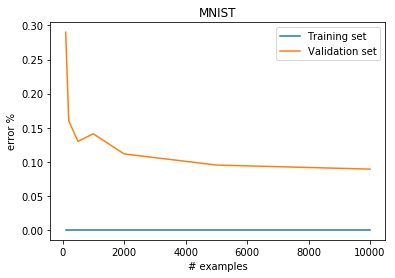

In [17]:
plt.plot(num_exs,mnist_train_err,label="Training set")
plt.plot(num_exs,mnist_val_err,label="Validation set")
plt.xlabel("# examples")
plt.ylabel("error %")
plt.title("MNIST")
plt.legend()
plt.show()

In [18]:
num_exs = [100, 200, 500, 1000, 2000, spam_xtrain.shape[0]] #number of examples
spam_train_err = []
spam_val_err = []
for num_ex in num_exs:
    train_err, val_err = \
    train(spam_xtrain, spam_ytrain, spam_xval, spam_yval, num_ex, "linear")
    spam_train_err.append(train_err)
    spam_val_err.append(val_err)

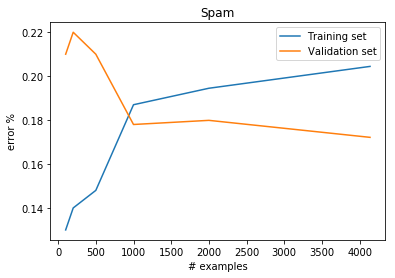

In [19]:
plt.plot(num_exs,spam_train_err,label="Training set")
plt.plot(num_exs,spam_val_err,label="Validation set")
plt.xlabel("# examples")
plt.ylabel("error %")
plt.title("Spam")
plt.legend()
plt.show()

In [20]:
num_exs = [100, 200, 500, 1000, 2000, 5000] #number of examples
cifar10_train_err = []
cifar10_val_err = []
for num_ex in num_exs:
    train_err, val_err = \
    train(cifar10_xtrain, cifar10_ytrain, cifar10_xval, cifar10_yval, \
          num_ex, "linear")
    cifar10_train_err.append(train_err)
    cifar10_val_err.append(val_err)

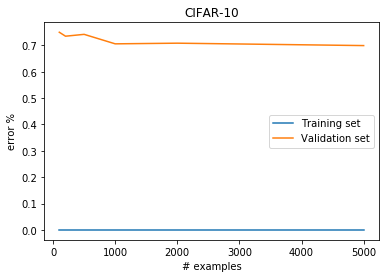

In [21]:
plt.plot(num_exs,cifar10_train_err,label="Training set")
plt.plot(num_exs,cifar10_val_err,label="Validation set")
plt.xlabel("# examples")
plt.ylabel("error %")
plt.title("CIFAR-10")
plt.legend()
plt.show()

\pagebreak 

# #4 Hyperparameter Tuning
#### Here I find the best value of the hyperparameter C on the MNIST dataset by computing and plotting error values for various values of C on a validation set. I created a modified training function from earlier that's reusable for further problems. Also note that gamma is set to "auto" as a default value because that's what scikit-learn uses as default. 

In [41]:
def train_hyper(data_xtrain,data_ytrain,data_xval,data_yval,\
                num_ex,kernel,C,gamma="auto"):
    data_ytrain = data_ytrain.reshape(-1,)
    data_yval = data_yval.reshape(-1,)
    model = svm.SVC(kernel=kernel, cache_size=4000, C=C, gamma=gamma)
    model.fit(data_xtrain[:num_ex],data_ytrain[:num_ex])
    return 1-accuracy_score(data_yval[:num_ex],model.predict(data_xval[:num_ex,:]))

num_ex = 10000
C = [0.01, 0.05, 0.1, 0.25, 0.5, 0.75, 1]
mnist_val_err = []
for c in C:
    val_err = \
    train_hyper(mnist_xtrain, mnist_ytrain, mnist_xval, mnist_yval, \
                num_ex, "linear", c)
    mnist_val_err.append(val_err)

#### The various and best C value(s) and their associated errors is/are listed/printed above the graph below.

C values tried with corresponding validation errors(C = key, error = value): 
0.01: 0.06689999999999996
0.05: 0.07920000000000005
0.1: 0.0837
0.25: 0.08909999999999996
0.5: 0.08919999999999995
0.75: 0.08919999999999995
1: 0.08919999999999995

Best C value for MNIST is: 0.01


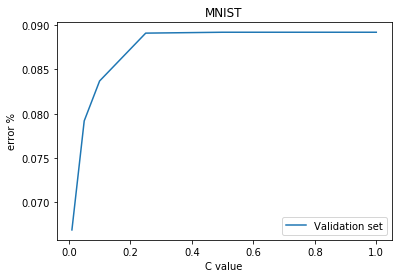

In [43]:
temp = dict(zip(C, mnist_val_err))
msg = ""
for c, err in temp.items():
    msg += str(c) + ": " + str(err) + "\n"
print("C values tried with corresponding validation errors"+ 
      "(C = key, error = value): \n" + msg)
print("Best C value for MNIST is: " + 
      str(C[mnist_val_err.index(min(mnist_val_err))]))
plt.plot(C, mnist_val_err,label="Validation set")
plt.xlabel("C value")
plt.ylabel("error %")
plt.title("MNIST")
plt.legend()
plt.show()

\pagebreak 

# #5 K-Fold Cross-Validation
#### Here I do 5-fold cross-validation on the entire training set portion of the SPAM dataset.

In [24]:
#get entire training set back
spam = io.loadmat("data/%s_data.mat" % "spam")
k = 5
spam_x, spam_y = spam["training_data"], spam["training_labels"]
fold_size = spam_x.shape[0]/k

def spam_folds_train(c):
    accs = []
    for i in range(k):
        val_begin = int(fold_size*i)
        val_end = int(fold_size*(i+1))
        spam_xval, spam_yval = \
        spam_x[val_begin:val_end], spam_y[val_begin:val_end]
        spam_xt, spam_yt = \
        np.vstack((spam_x[:val_begin],spam_x[val_end:])),\
        np.vstack((spam_y[:val_begin],spam_y[val_end:]))
        accs.append(train_hyper(spam_xt, spam_yt, spam_xval, 
                                spam_yval, spam_xt.shape[0], "linear", c))
    return accs

In [25]:
spam_folds_val_acc = [spam_folds_train(c) for c in C]
spam_folds_val_acc = [sum(i)/len(i) for i in spam_folds_val_acc]

#### The cross-validation scores for various and best C value(s) is/are listed/printed below the following code cell.

In [49]:
temp = dict(zip(C, spam_folds_val_acc))
msg = ""
for c, acc in temp.items():
    msg += str(c) + ": " + str(acc) + "\n"
print("C values tried with corresponding Cross-Validation accuracies"+
      "\n(C = key, accuracy = value): \n" + msg)
print("Best C value: " + str(C[spam_folds_val_acc.index(min(spam_folds_val_acc))]))

C values tried with corresponding Cross-Validation accuracies
(C = key, accuracy = value): 
0.01: 0.2839301432455919
0.05: 0.25182033096926715
0.1: 0.24814603014417996
0.25: 0.2433098795540979
0.5: 0.23944140760051952
0.75: 0.2388602023939675
1: 0.23905325222624024

Best C value: 0.75


\pagebreak 

# #6 Kaggle
#### Here I prepare to submit prediction to Kaggle through multiple steps.
#### 1) I preprocess if necessary (i.e. MNIST rescale/standardize). 
#### 2) I find the best set of hyperparameters through trying out combos. 
#### 3) I use my findings from steps 1 and 2 to generate predictions. Note that I modified the provided "results_to_csv" function so I could give clearer names to the generated files. 
#### Kaggle username: danish123
#### Kaggle MNIST score: 0.97000
#### Kaggle SPAM score: 0.80535
#### Kaggle CIFAR-10 score: 0.40500

In [27]:
mnist_kaggle_vals = [] #validation values
C = [0.01, 0.5, 1.0]
gammas = [0.001, 0.01, 0.1]
kernels = ["poly","rbf"]
for c in C:
    for gamma in gammas:
        for kernel in kernels:
            val_err = \
            train_hyper(mnist_xtrain, mnist_ytrain, mnist_xval, mnist_yval, \
                        2000, kernel, c, gamma)
            mnist_kaggle_vals.append((val_err,kernel,c,gamma))

In [28]:
print("best combo (kernel,c,gamma)"+str(min(mnist_kaggle_vals, key = lambda x: x[0]))) 

best combo (kernel,c,gamma)(0.0625, 'poly', 0.01, 0.1)


In [29]:
def test(data_xtrain, data_ytrain, data_xtest, num_ex, kernel, C, gamma):
    data_ytrain = data_ytrain.reshape(-1,)
    model = svm.SVC(cache_size=4000,kernel=kernel,C=C,gamma=gamma)
    model.fit(data_xtrain[:num_ex,:],data_ytrain[:num_ex])
    return model.predict(data_xtest)

In [31]:
mnist_xtest = io.loadmat("data/%s_data.mat" % "mnist")["test_data"]
mnist_xtest = (mnist_xtest-np.mean(mnist_xtest))/np.std(mnist_xtest)
results_to_csv(test(mnist_xtrain, mnist_ytrain, mnist_xtest, \
                    10000, "poly", 0.01, 0.1),"mnist")

In [32]:
spam_kaggle_vals = [] #validation values
C = [0.01, 0.5, 1, 5, 10, 100, 500, 1000]
gammas = [0.001, 0.01, 0.1]
kernels = ["poly","rbf"]
for c in C:
    for gamma in gammas:
        for kernel in kernels:
            val_err = \
            train_hyper(spam_xtrain, spam_ytrain, spam_xval, spam_yval, \
                        2000, kernel, c, gamma)
            spam_kaggle_vals.append((val_err,kernel,c,gamma))

In [33]:
print("best combo (kernel,c,gamma)"+str(min(spam_kaggle_vals, key = lambda x: x[0])))

best combo (kernel,c,gamma)(0.17601547388781436, 'rbf', 1000, 0.001)


In [50]:
spam_xtest = io.loadmat("data/%s_data.mat" % "spam")["test_data"]
results_to_csv(test(spam_xtrain, spam_ytrain, spam_xtest,\
                    10000, "rbf", 1000, 0.001),"spam")

In [35]:
#this takes much longer to train than the above 2 datasets...
cifar10_kaggle_vals = [] #validation values
C = [0.01, 0.5, 1.0]
gammas = [0.001, 0.01, 0.1]
kernels = ["poly","rbf"]
for c in C:
    for gamma in gammas:
        for kernel in kernels:
            val_err = \
            train_hyper(cifar10_xtrain, cifar10_ytrain, cifar10_xval, cifar10_yval, \
                        2000, kernel, c, gamma)
            cifar10_kaggle_vals.append((val_err,kernel,c,gamma))

In [36]:
min_index = cifar10_kaggle_vals.index(min(cifar10_kaggle_vals))
print("best combo (kernel,c,gamma)"
      +str(min(cifar10_kaggle_vals, key = lambda x: x[0])))

best combo (kernel,c,gamma)(0.6635, 'poly', 0.01, 0.001)


In [37]:
cifar10_xtest = io.loadmat("data/%s_data.mat" % "cifar10")["test_data"]
results_to_csv(test(cifar10_xtrain, cifar10_ytrain, cifar10_xtest, 10000, 
                    "poly", 0.01, 0.001), "cifar10")